<a href="https://colab.research.google.com/github/SinUbyCosU/Computer-Vision/blob/main/CameraCalibrationDLT_LevenbergMarquardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

# Step 1: Generate synthetic 3D points
def generate_3d_points(n=20):
    X = np.random.uniform(-1, 1, (3, n))
    X = np.vstack((X, np.ones((1, X.shape[1]))))  # Homogeneous coordinates
    return X

# Step 2: Define camera intrinsics and extrinsics
def create_camera():
    K = np.array([[800, 0, 320],
                  [0, 800, 240],
                  [0,   0,   1]])
    R = np.eye(3)
    t = np.array([[0], [0], [-5]])
    Rt = np.hstack((R, t))
    P = K @ Rt
    return P, K, R, t

# Step 3: Project 3D points to 2D
def project_points(P, X):
    x = P @ X
    x /= x[2]
    return x[:2]

# Step 4: Construct matrix A for DLT
def construct_A(X, x):
    n = X.shape[1]
    A = []
    for i in range(n):
        X_i = X[:, i]
        u, v = x[0, i], x[1, i]
        A.append(np.hstack([np.zeros(4), -X_i, v * X_i]))
        A.append(np.hstack([X_i, np.zeros(4), -u * X_i]))
    return np.array(A)

# Step 5: Solve using SVD
def solve_dlt(A):
    _, _, Vt = np.linalg.svd(A)
    m = Vt[-1]
    M_est = m.reshape((3, 4))
    return M_est

# Step 6: Evaluate reprojection error
def reprojection_error(P_est, X, x_true):
    x_proj = P_est @ X
    x_proj /= x_proj[2]
    error = np.linalg.norm(x_true - x_proj[:2], axis=0).mean()
    return error

# Full pipeline
X = generate_3d_points()
P_true, K_true, R_true, t_true = create_camera()
x = project_points(P_true, X)
A = construct_A(X, x)
P_est = solve_dlt(A)
error = reprojection_error(P_est, X, x)

# Decomposition using OpenCV (optional)
K_est, R_est, t_est, _, _, _, _ = cv2.decomposeProjectionMatrix(P_est)

error, P_est, K_est / K_est[2, 2]  # Return reprojection error, estimated P, normalized K


(np.float64(1.1313533914343341e-11),
 array([[ 3.42996351e-01, -6.33911326e-15,  1.37198540e-01,
         -6.85992701e-01],
        [-2.73021352e-14,  3.42996351e-01,  1.02898905e-01,
         -5.14494526e-01],
        [-1.18286457e-16, -2.11419424e-17,  4.28745438e-04,
         -2.14372719e-03]]),
 array([[ 8.0000000e+02, -7.8464388e-11,  3.2000000e+02],
        [ 0.0000000e+00,  8.0000000e+02,  2.4000000e+02],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]))

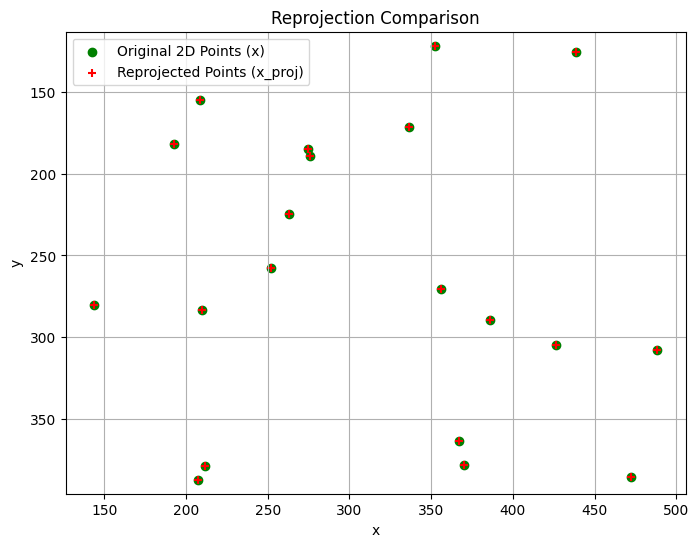

In [ ]:
def plot_reprojection(x_true, P_est, X):
    x_proj = P_est @ X
    x_proj /= x_proj[2]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_true[0], x_true[1], label='Original 2D Points (x)', c='green')
    plt.scatter(x_proj[0], x_proj[1], label='Reprojected Points (x_proj)', c='red', marker='+')
    for i in range(x_true.shape[1]):
        plt.plot([x_true[0, i], x_proj[0, i]], [x_true[1, i], x_proj[1, i]], 'gray', linestyle='--', alpha=0.5)
    plt.title('Reprojection Comparison')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_reprojection(x, P_est, X)


Reprojection error with noise: 2.583121942429175


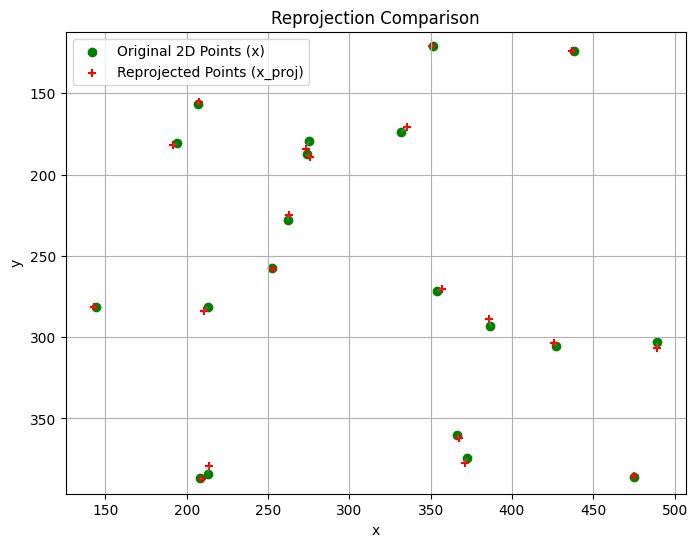

In [ ]:
def add_noise_to_2d(x, std=1.0):
    noise = np.random.normal(0, std, x.shape)
    return x + noise

x_noisy = add_noise_to_2d(x, std=2.0)
A_noisy = construct_A(X, x_noisy)
P_est_noisy = solve_dlt(A_noisy)
error_noisy = reprojection_error(P_est_noisy, X, x_noisy)
print("Reprojection error with noise:", error_noisy)
plot_reprojection(x_noisy, P_est_noisy, X)


Reprojection error after LM optimization: 0.0


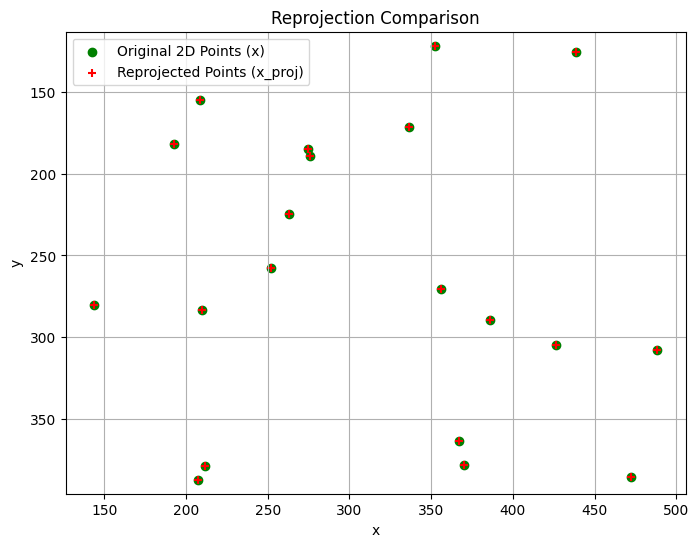

In [ ]:

# --- Levenberg-Marquardt Optimization of Camera Extrinsics ---

from scipy.optimize import least_squares

# Project 3D points using extrinsics and intrinsics
def project_points_rt(X, rvec, tvec, K):
    R, _ = cv2.Rodrigues(rvec)
    P = K @ np.hstack((R, tvec.reshape(3, 1)))
    x = P @ X
    x /= x[2]
    return x[:2]

# Residuals between observed and reprojected points
def residuals(params, X, x_obs, K):
    rvec = params[:3]
    tvec = params[3:6]
    x_proj = project_points_rt(X, rvec, tvec, K)
    return (x_proj - x_obs).ravel()

# Initial guess: from ground truth in synthetic setup
rvec_init = np.zeros(3)
tvec_init = np.array([0, 0, -5])
params_init = np.hstack((rvec_init, tvec_init))

# Levenberg-Marquardt optimization
res = least_squares(residuals, params_init, method='lm', args=(X, x, K_true))

# Extract optimized parameters
rvec_opt, tvec_opt = res.x[:3], res.x[3:6]
R_opt, _ = cv2.Rodrigues(rvec_opt)
P_opt = K_true @ np.hstack((R_opt, tvec_opt.reshape(3, 1)))

# Reprojection error after LM optimization
error_lm = reprojection_error(P_opt, X, x)
print("Reprojection error after LM optimization:", error_lm)

# Plot optimized reprojections
plot_reprojection(x, P_opt, X)
